# Variational Auto Encoder (VAE) -MNIST Augmentation

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import trange

2021-09-25 06:59:31.021713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Utilities

In [2]:
def plot_results(images, n_cols=None, title=None):
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    fig = plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
    plt.suptitle(title)

In [3]:
BATCH_SIZE = 128
CODINGS_SIZE = 32
N_EPOCHS = 150

# Prepare the Dataset

In [4]:
def prepare_data(label, batch_size):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1)
    X_train = X_all[np.where(y_all == label)]

    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    
    return dataset

def prepare_images(label):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]
    
    return X_train

# Build the Model

A variational Auto Encoder has mainly 2 components
* **Encoder**
* **Decoder**

In [5]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
def build_encoder():
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    z_mean = keras.layers.Dense(CODINGS_SIZE, name="z_mean")(x)
    z_log_var = keras.layers.Dense(CODINGS_SIZE, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [7]:
def build_decoder():
    latent_inputs = keras.Input(shape=(CODINGS_SIZE,))
    x = keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = keras.layers.Reshape((7, 7, 64))(x)
    x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

2021-09-25 06:59:35.098811: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-25 06:59:35.102187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-25 06:59:35.144979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 06:59:35.145842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-25 06:59:35.145940: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-25 06:59:35.172339: I tensorflow/stream_executor/platform/def

Encoder Summary


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
__________________________________________________________________________

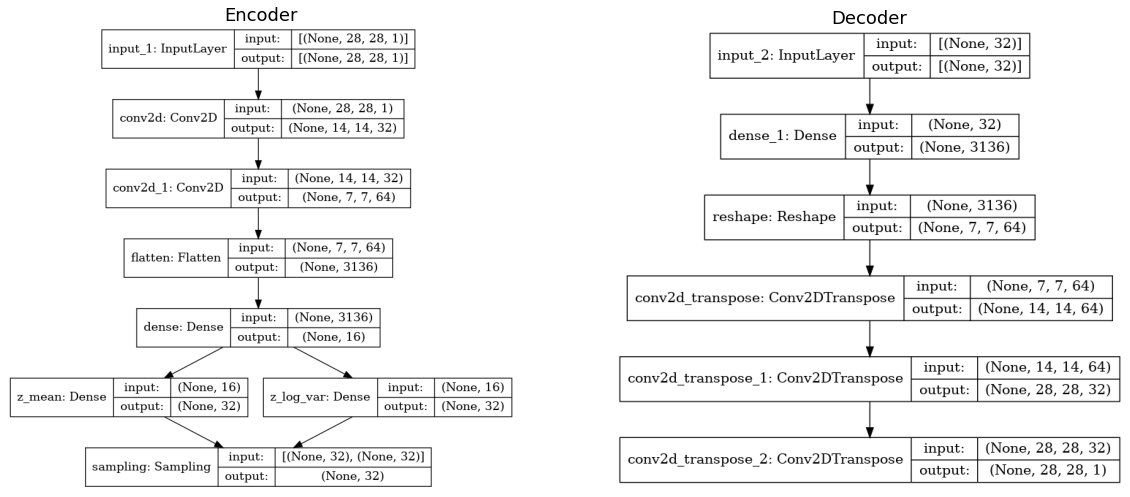

In [9]:
encoder = build_encoder()
decoder = build_decoder()
print('Encoder Summary\n\n')
encoder.summary()
print('\n\nDecoder Summary\n\n')
decoder.summary()
keras.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')
keras.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder', fontsize=18)
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder', fontsize=18)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# VAE in Action

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/150


2021-09-25 06:59:39.973040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-25 06:59:39.982512: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz
2021-09-25 06:59:40.149857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-25 06:59:40.903102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-25 06:59:40.917647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


53/53 [==============================] - 7s 7ms/step - loss: 436.5054 - reconstruction_loss: 337.9589 - kl_loss: 4.3852
Epoch 2/150
53/53 [==============================] - 0s 7ms/step - loss: 223.5779 - reconstruction_loss: 216.1908 - kl_loss: 3.5453
Epoch 3/150
53/53 [==============================] - 0s 7ms/step - loss: 215.6266 - reconstruction_loss: 210.2482 - kl_loss: 3.3318
Epoch 4/150
53/53 [==============================] - 0s 7ms/step - loss: 212.0416 - reconstruction_loss: 206.8323 - kl_loss: 3.2494
Epoch 5/150
53/53 [==============================] - 0s 7ms/step - loss: 206.4130 - reconstruction_loss: 198.7406 - kl_loss: 3.4859
Epoch 6/150
53/53 [==============================] - 0s 7ms/step - loss: 194.3831 - reconstruction_loss: 188.9122 - kl_loss: 4.0244
Epoch 7/150
53/53 [==============================] - 0s 7ms/step - loss: 191.2393 - reconstruction_loss: 185.7952 - kl_loss: 4.3404
Epoch 8/150
53/53 [==============================] - 0s 7ms/step - loss: 189.0320 - reco

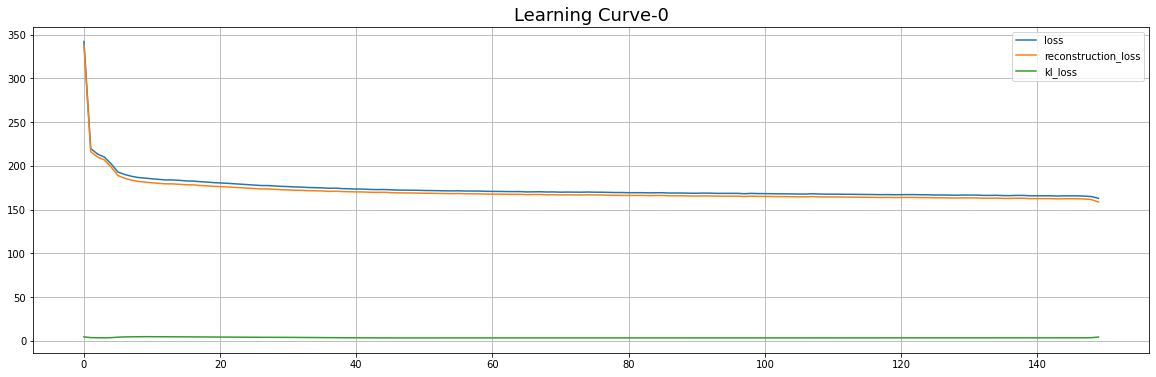

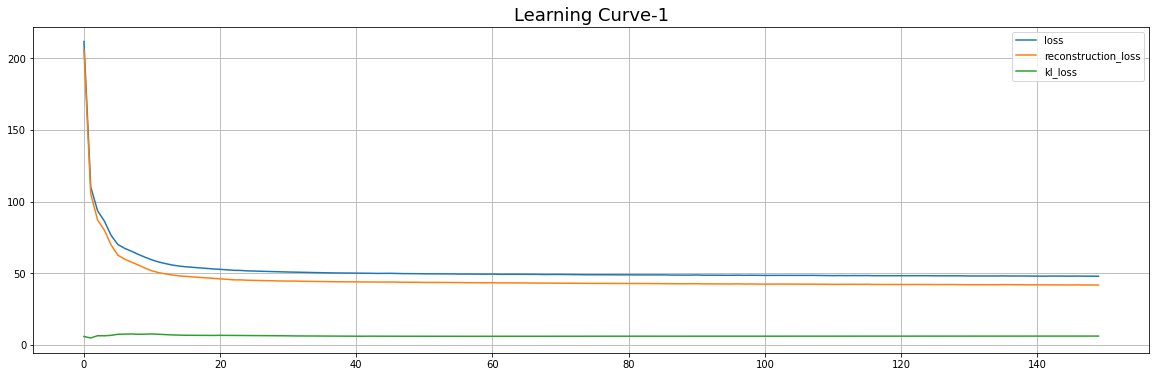

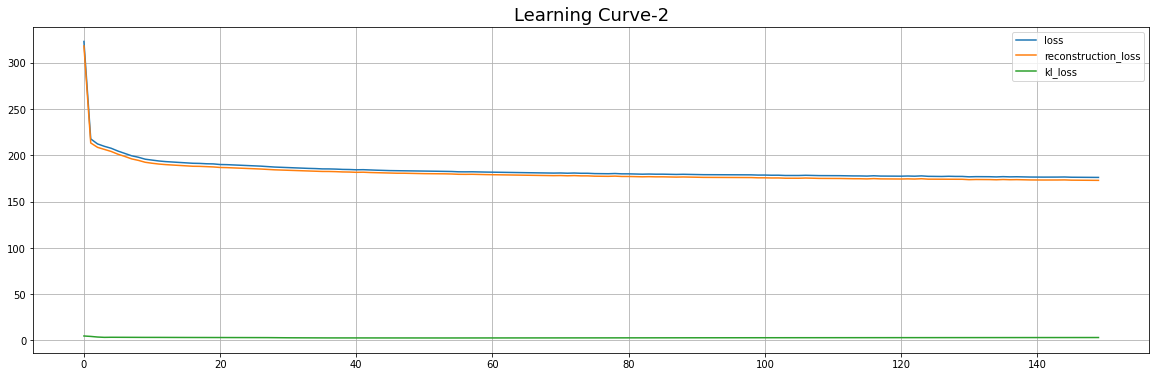

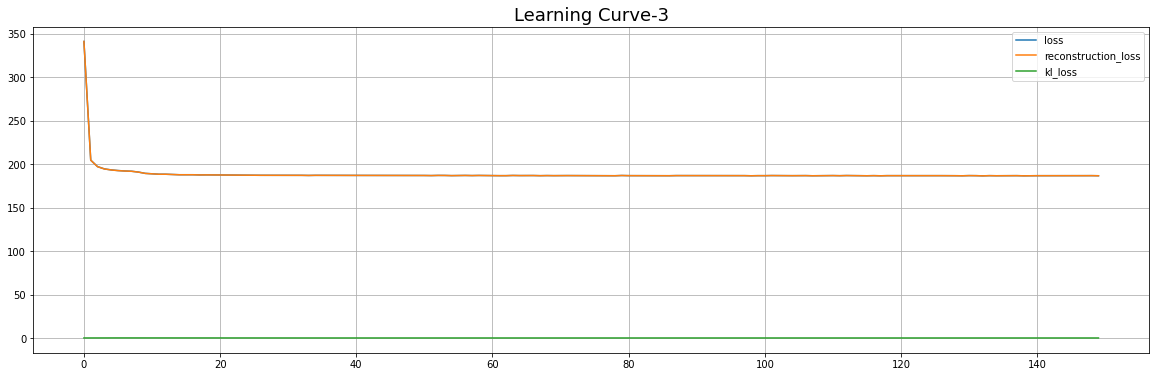

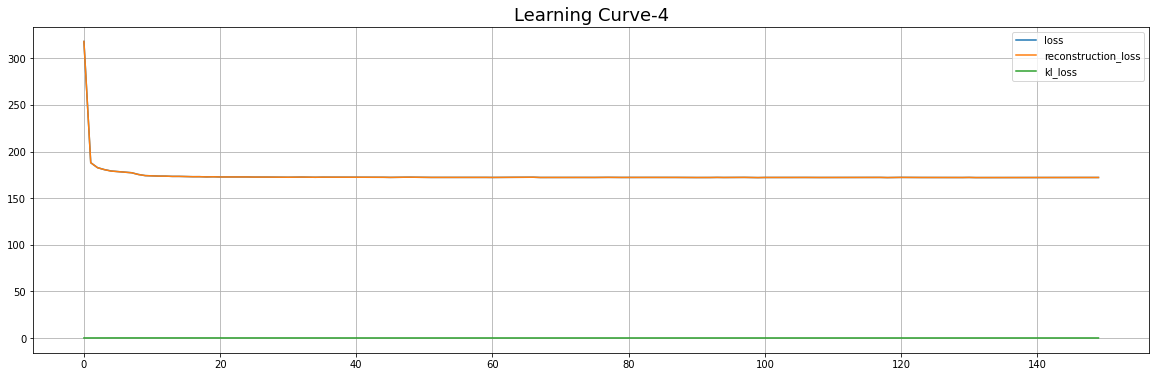

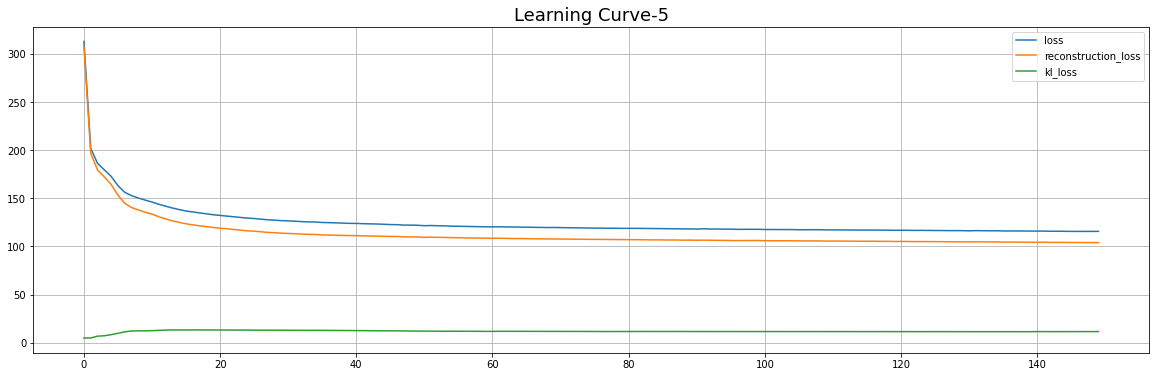

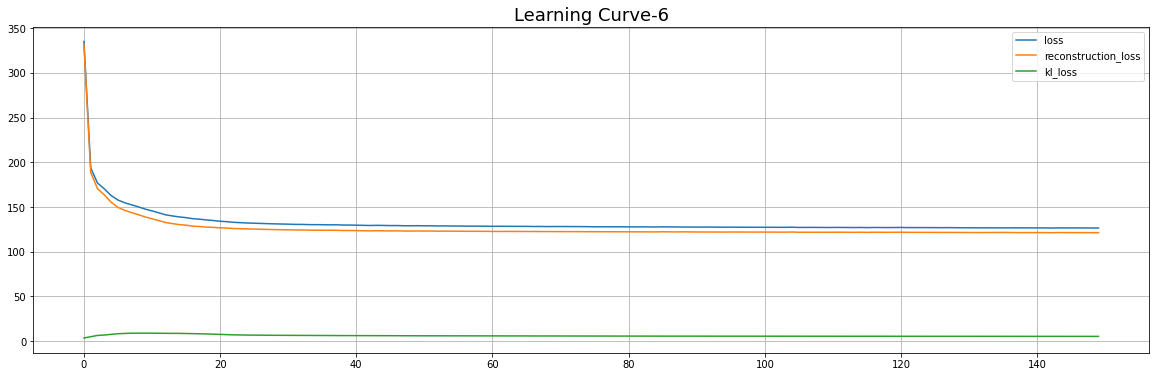

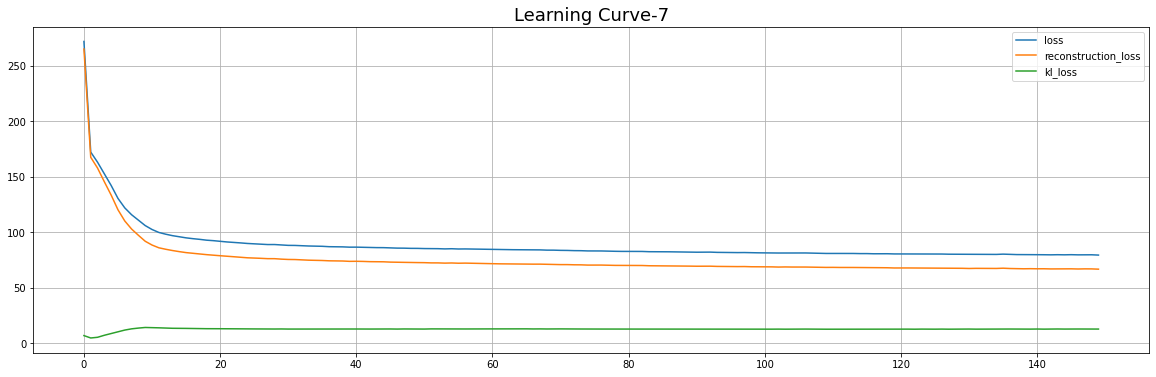

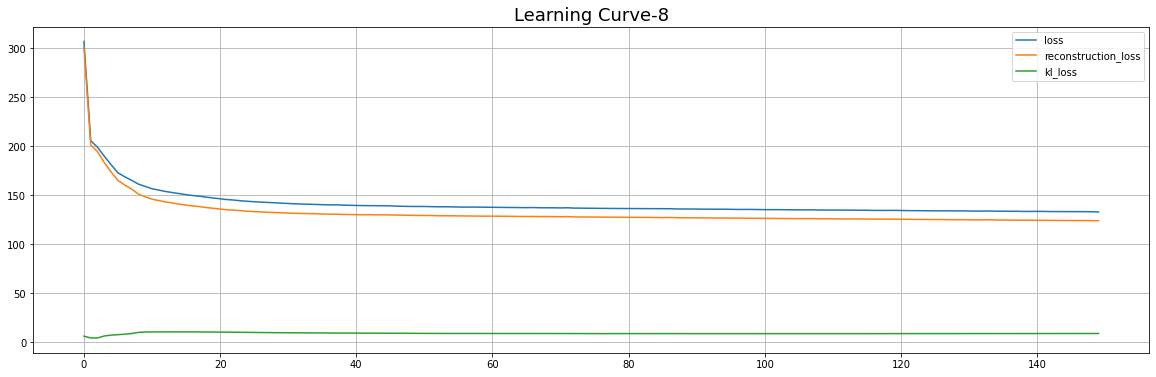

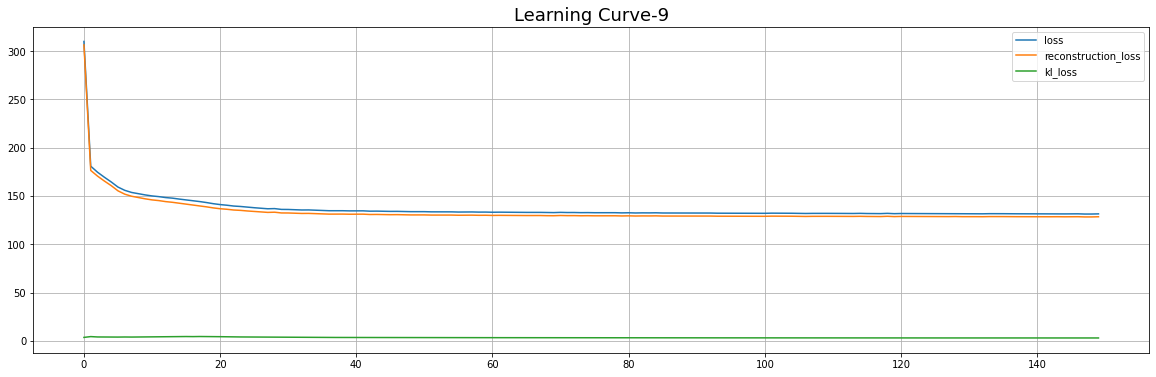

In [10]:
for i in range(10):
    LABEL = i
    dataset = prepare_data(LABEL, BATCH_SIZE)

    encoder = build_encoder()
    decoder = build_decoder()
    
    gan = VAE(
        encoder=encoder, decoder=decoder, 
    )
    gan.compile(
        keras.optimizers.Adam(learning_rate=0.001),
    )
    
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Learning Curve-{LABEL}', fontsize=18)
    history = gan.fit(dataset, epochs=N_EPOCHS, verbose=1)
    pd.DataFrame(history.history).plot(ax=ax)
    ax.grid()
       
    decoder.save(f'MNIST-AUG-VAE-{LABEL}.h5')

# Generated Images

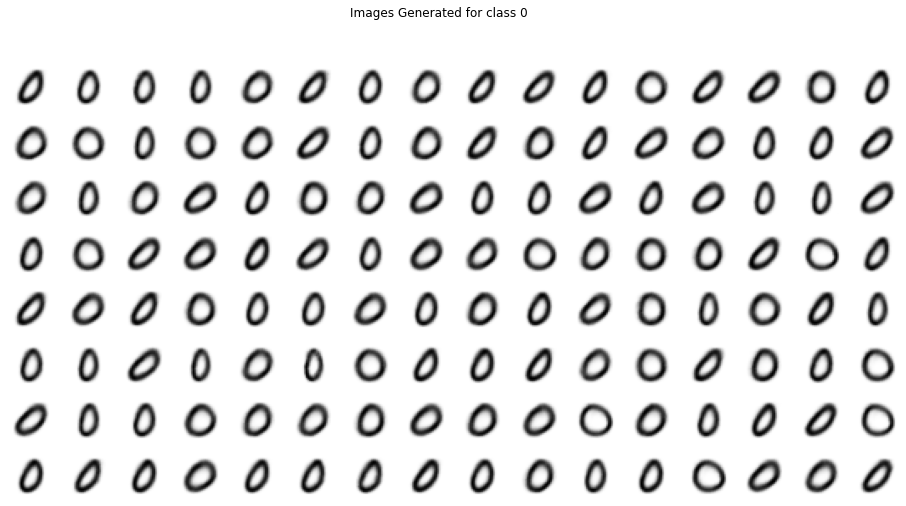

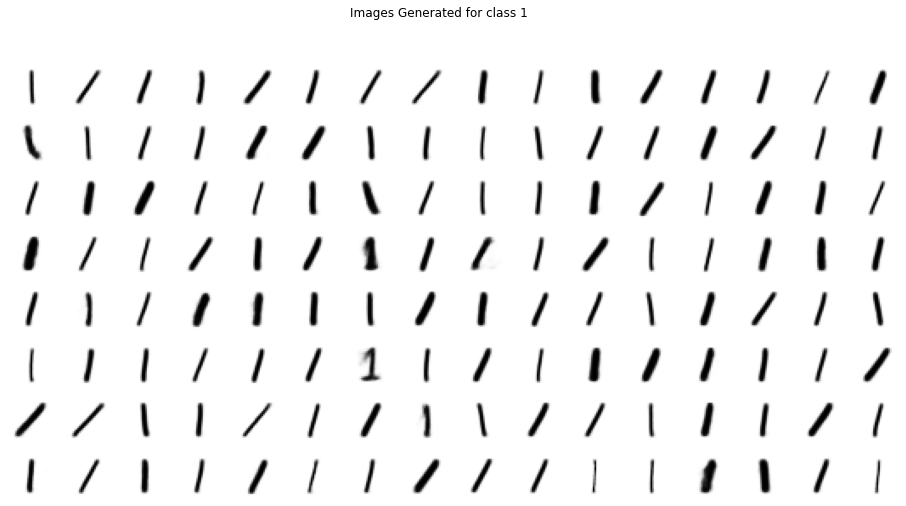

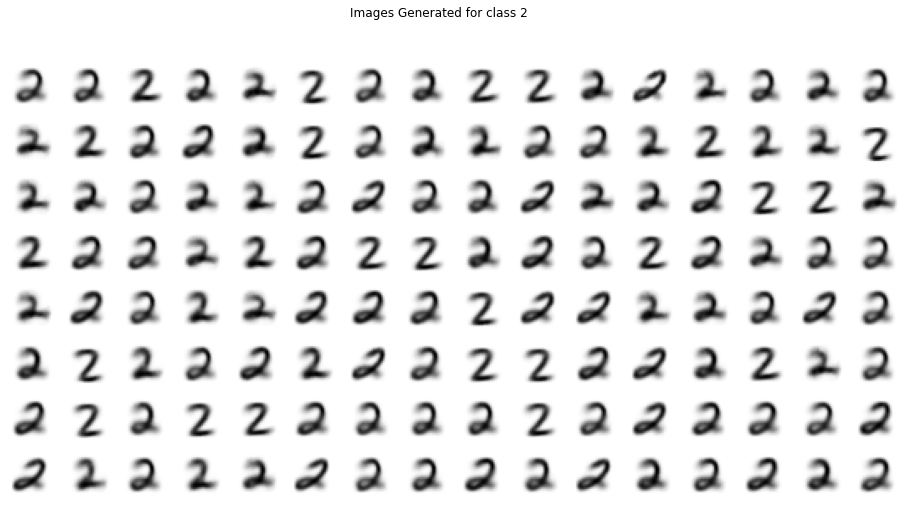

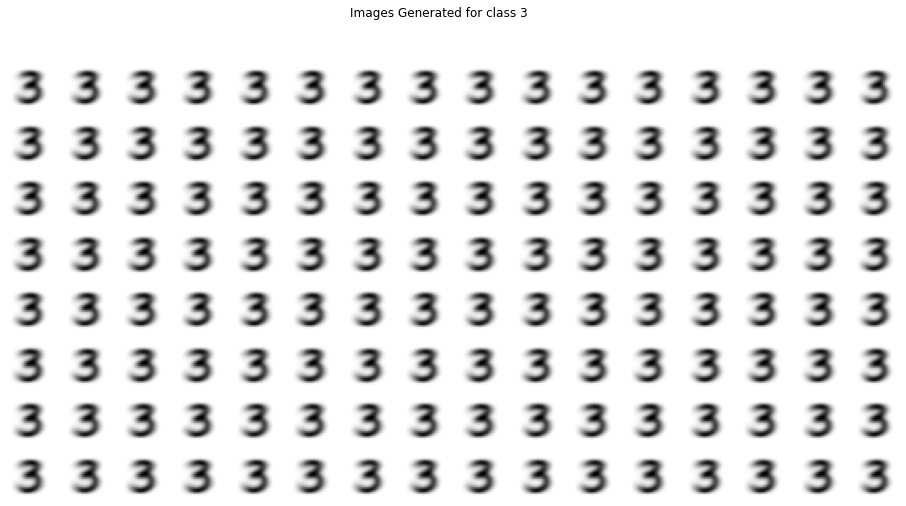

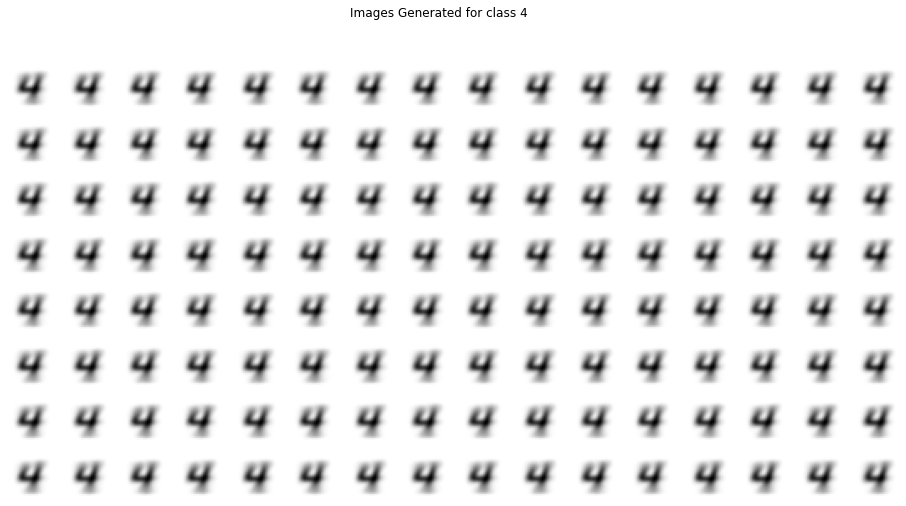

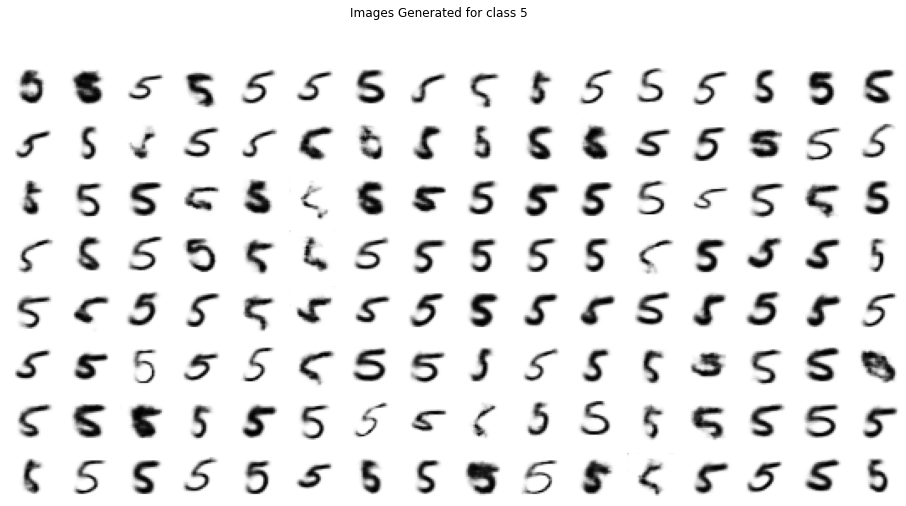

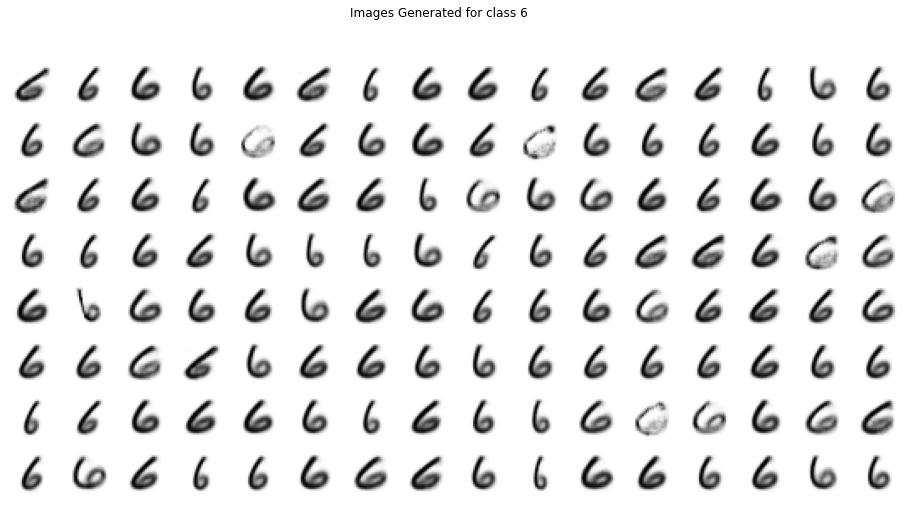

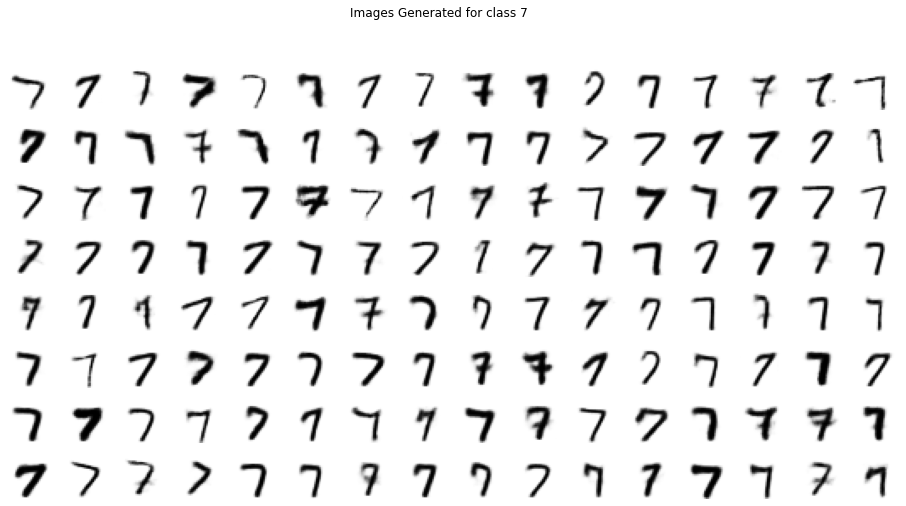

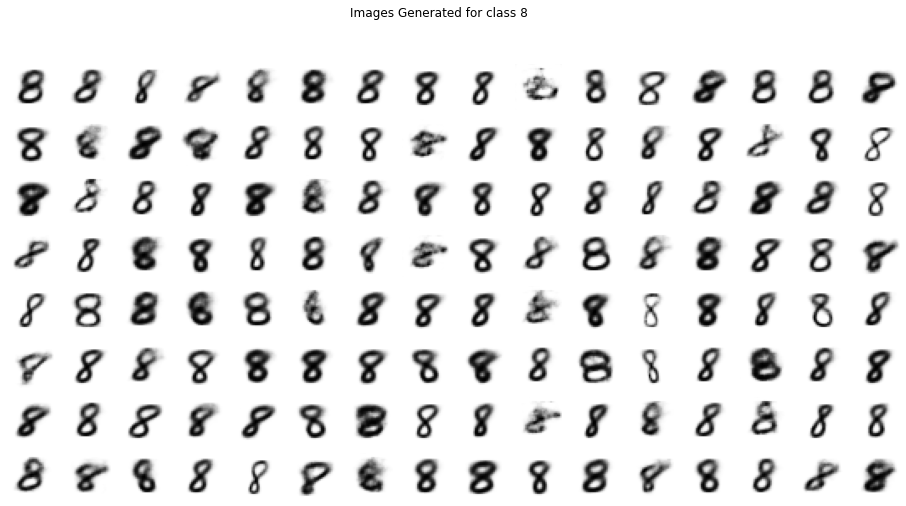

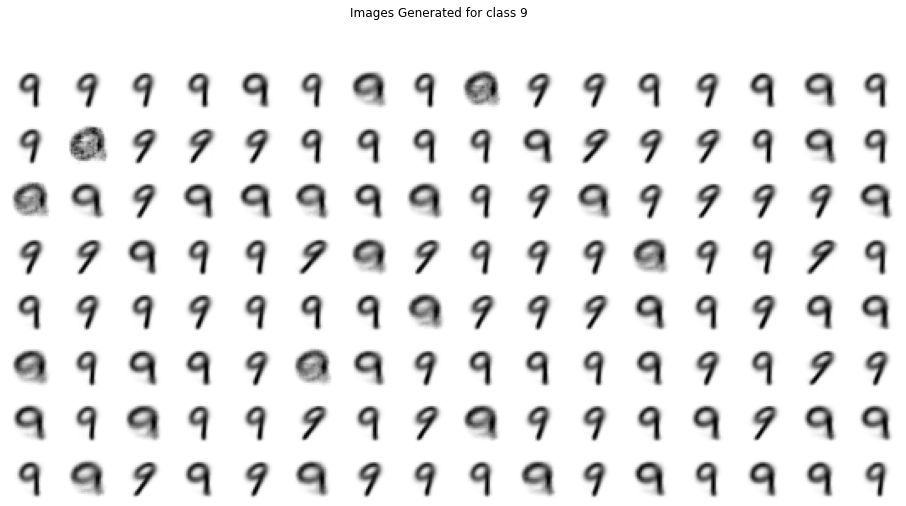

In [11]:
from scipy.linalg import sqrtm

def frechet_distance(act1, act2):
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

evaluator = keras.models.Sequential(keras.models.load_model('../input/mnist-net/mnist_net.h5').layers[:-1])
scores = []

for i in range(10):
    decoder = keras.models.load_model(f'MNIST-AUG-VAE-{i}.h5')
    fake_images = decoder(tf.random.normal([128, CODINGS_SIZE]))
    embeddings_real = evaluator(prepare_images(i))
    embeddings_fake = evaluator(fake_images)
    scores.append(frechet_distance(embeddings_real, embeddings_fake))
    plot_results(fake_images, 16, f'Images Generated for class {i}')
    plt.show()

# Evaluation

In [12]:
pd.Series(scores, name="Frechet Distance")

0    230.377605
1     51.841330
2    147.385780
3    129.078309
4    306.957822
5     90.197605
6    161.613348
7     26.863205
8    105.850172
9    435.726686
Name: Frechet Distance, dtype: float64